In [1]:
import os
import pickle

import numpy as np
import pandas as pd

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.models import model_from_yaml
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image as kimage
from keras.callbacks import EarlyStopping
import sklearn.metrics as skmetrics

# Since default progress bars seem to crash Chrome
from keras_tqdm import TQDMNotebookCallback

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


# Pre-trained Model with Modifications
Following the tutorial from: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html and
https://blog.nycdatascience.com/student-works/deep-learning-meets-recommendation-systems/

## Load training and validation images

In [2]:
train_dir = "data/posters_split/train/"
validation_dir = "data/posters_split/validation/"

In [3]:
train_filenames = os.listdir(train_dir)
n_train = len(train_filenames)

validation_filenames = os.listdir(validation_dir)
n_validation = len(validation_filenames)

In [4]:
# Load train images in arrays
images=[None]*n_train
X=[None]*n_train

for i, train_filename in enumerate(train_filenames):
    images[i] = kimage.load_img(train_dir + train_filename, target_size=(224, 224))
    X[i] = kimage.img_to_array(images[i])
    X[i] = np.expand_dims(X[i], axis=0)
    X[i] = preprocess_input(X[i]).reshape(224,224,3)  

In [5]:
# Load validation images in arrays
val_images=[None]*n_validation
val_X=[None]*n_validation

for i, validation_filename in enumerate(validation_filenames):
    val_images[i] = kimage.load_img(validation_dir + validation_filename, target_size=(224, 224))
    val_X[i] = kimage.img_to_array(val_images[i])
    val_X[i] = np.expand_dims(val_X[i], axis=0)
    val_X[i] = preprocess_input(val_X[i]).reshape(224,224,3)  

## Load binary encoded response vectors for train and validation datasets

In [6]:
train_multilabels = pd.read_csv("data/train_labels.csv", index_col=0)
val_multilabels = pd.read_csv("data/val_labels.csv", index_col=0)

In [7]:
# Index is TMDB id, 20 columns correspond to the genres
print train_multilabels.shape, val_multilabels.shape

(9108, 20) (1139, 20)


In [8]:
train_multilabels.head()

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science_Fiction,TV_Movie,Thriller,War,Western
id,,,,,,,,,,,,,,,,,,,,
80,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
430780,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
7985,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
53157,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
43821,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1


In [9]:
# Get ids for train and val datasets in order the images were loaded in
train_ids = [int(filename.split("-")[-1].split("_")[0]) for filename in train_filenames]
val_ids = [int(filename.split("-")[-1].split("_")[0]) for filename in validation_filenames]

assert(len(train_ids) == len(train_multilabels))
assert(len(val_ids) == len(val_multilabels))

# Reorder rows of multilabel dataframes based on the order the images were loaded in 
train_multilabels = train_multilabels.reindex(train_ids)
val_multilabels = val_multilabels.reindex(val_ids)

## Use pretrained CNN to extract bottleneck features

In [10]:
# Get bottleneck features from pretrained VGG16 
pretrained_model = VGG16(include_top=False, weights='imagenet')

X = np.array(X)
val_X = np.array(val_X)
train_features = pretrained_model.predict(X)
val_features = pretrained_model.predict(val_X)

# Save bottleneck features
np.save(open('bottleneck_features_train.npy', 'w'), train_features)
# Save bottleneck features
np.save(open('bottleneck_features_validation.npy', 'w'), val_features)

In [7]:
X.shape

(9291, 224, 224, 3)

## (Optional: Only if you have the bottleneck features and want to load them to save time)

In [9]:
# Load bottleneck features
train_features = np.load('bottleneck_features_train.npy')
val_features = np.load('bottleneck_features_validation.npy')

## Add a fully-connected layer on top and train on bottleneck features

In [11]:
# Train a small fully-connected model on the bottleneck features
model = Sequential()
model.add(Flatten(input_shape=train_features.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(train_multilabels.shape[1], activation='sigmoid'))

model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_features, train_multilabels.values,
          epochs=50,
          batch_size=16,
          validation_data=(val_features, val_multilabels.values),
          verbose=0,
          callbacks=[TQDMNotebookCallback()])
model.save_weights('bottleneck_fc_model.h5')

6064/|/[loss: 0.330, acc: 0.872]  67%|| 6064/9108 [00:13<00:01, 1912.66it/s]

In [22]:
# serialize model to YAML
model_yaml = model.to_yaml()
with open("model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)

In [14]:
# Get probability predictions for each of the classes
train_probs = model.predict_proba(train_features)
val_probs = model.predict_proba(val_features)

 896/1139 [======================>.......] - ETA: 0s

In [18]:
# save train and validation probabilities and actual values
np.save(open('train_probs.npy', 'w'), train_probs)
np.save(open('val_probs.npy', 'w'), val_probs)
np.save(open('train_multilabels.npy', 'w'), train_multilabels)
np.save(open('val_multilabels.npy', 'w'), val_multilabels)

## Load model from yaml

In [5]:
yaml_file = open('model.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
model = model_from_yaml(loaded_model_yaml)
# load weights into new model
model.load_weights("bottleneck_fc_model.h5")
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Evaluation of performance

In [15]:
# once training is complete, let's see how well we have done
score = model.evaluate(train_features, train_multilabels.values, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

score = model.evaluate(val_features, val_multilabels.values, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

('Train loss:', 0.29349702812623285)
('Train accuracy:', 0.87715210608866423)
('Validation loss:', 0.44302287360259168)
('Validation accuracy:', 0.86382806484274322)


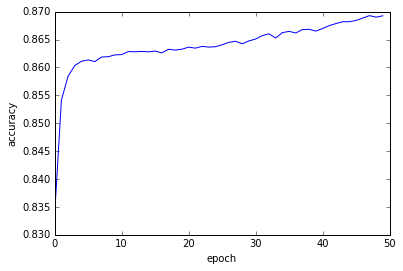

In [16]:
# here is a visualization of the training process
# typically we gain a lot in the beginning and then
# training slows down
plt.plot(history.history['acc'])
plt.xlabel("epoch")
plt.ylabel("accuracy")

In [39]:
# Find best thresholds for predicting 1 for each genre based on
# Matthews correlation coefficient
y_val = val_multilabels.values

# Range of threshold values to try
threshold = np.arange(0.0,0.9,0.01)

acc = []
accuracies = []
# Store best threshold for each genre
best_threshold = np.zeros(train_probs.shape[1])
for i in range(train_probs.shape[1]):
    y_prob = np.array(train_probs[:,i])
    for j in threshold:
        y_pred = [1 if prob >= j else 0 for prob in y_prob]
        acc.append(skmetrics.matthews_corrcoef(train_multilabels.values[:,i], y_pred))
    acc   = np.array(acc)
    index = np.where(acc==acc.max()) 
    accuracies.append(acc.max()) 
    best_threshold[i] = threshold[index[0][0]]
    acc = []

print best_threshold

# Predict on validation data based on genre thresholds found for train data
y_pred = np.array([[1 if val_probs[i,j]>=best_threshold[j] else 0 for j in range(val_multilabels.shape[1])] for i in range(len(y_val))])

[ 0.24  0.18  0.09  0.25  0.19  0.08  0.47  0.07  0.13  0.08  0.11  0.2
  0.04  0.16  0.08  0.16  0.07  0.33  0.1   0.05]


In [41]:
print 'Performance of CNN Predictions with Matthews Thresholding'
print 'hamming loss:', skmetrics.hamming_loss(y_val, y_pred)
print 'jaccard similarity:', skmetrics.jaccard_similarity_score(y_val, y_pred)
print 'zero one loss:', skmetrics.zero_one_loss(y_val, y_pred)
print 'exact match ratio:', skmetrics.accuracy_score(y_val, y_pred)

Performance of CNN Predictions with Matthews Thresholding
hamming loss: 0.346927129061
jaccard similarity: 0.12079112419
zero one loss: 0.995610184372
exact match ratio: 0.00438981562774
